# High-Pass biquad filter implementation into lattice filter and comparison between the two implementations

## 1. Biquad characteristics

In this section we propose a Biquad filter with 3 stages of sos. And we show how it compares characteristically to a lattice implementation and how we do that using our API. we first take a look at our filter's coefficients as sos form.

### 1.1 Mathematical representation

In [1]:
%reload_ext autoreload
%autoreload 2
import numpy as np, scipy.signal as sig
import matplotlib.pyplot as plt

sos_den = np.array([1.0,-1.73052156, 0.75063326,
                          1. , -1.78411206, 0.81148717,
                          1. , -1.89080477, 0.92672506 ], dtype=np.float64)
sos_num = np.array([0.870571  , -1.74016541,  0.870571  ,
                          0.90084536, -1.7940611 ,  0.90084536,
                          0.95815912, -1.90136418,  0.95815912],dtype=np.float64)

sos_a = sos_den.reshape(3,3)
sos_b = sos_num.reshape(3,3)

sos = np.column_stack((sos_b,sos_a))
print("SOS array (cascade of 3 biquads):")
print(sos)

SOS array (cascade of 3 biquads):
[[ 0.870571   -1.74016541  0.870571    1.         -1.73052156  0.75063326]
 [ 0.90084536 -1.7940611   0.90084536  1.         -1.78411206  0.81148717]
 [ 0.95815912 -1.90136418  0.95815912  1.         -1.89080477  0.92672506]]


A better representation would be:

In [2]:
from IPython.display import Math, display
fractions = []
for k in range(3):
    b0, b1, b2 = sos_b[k]
    a0, a1, a2 = sos_a[k]
    frac = f"\\frac{{{b0:.2f} + {b1:.2f} z^{{-1}} + {b2:.2f} z^{{-2}}}}{{1 + {a1:.2f} z^{{-1}} + {a2:.2f} z^{{-2}}}}"
    fractions.append(frac)

# Display the cascaded transfer function
cascaded = " \\cdot ".join(fractions)
display(Math(f"H(z) = {cascaded}"))


<IPython.core.display.Math object>

### 1.2 Impulse Response
Using the following snippet we plot the impulse response.

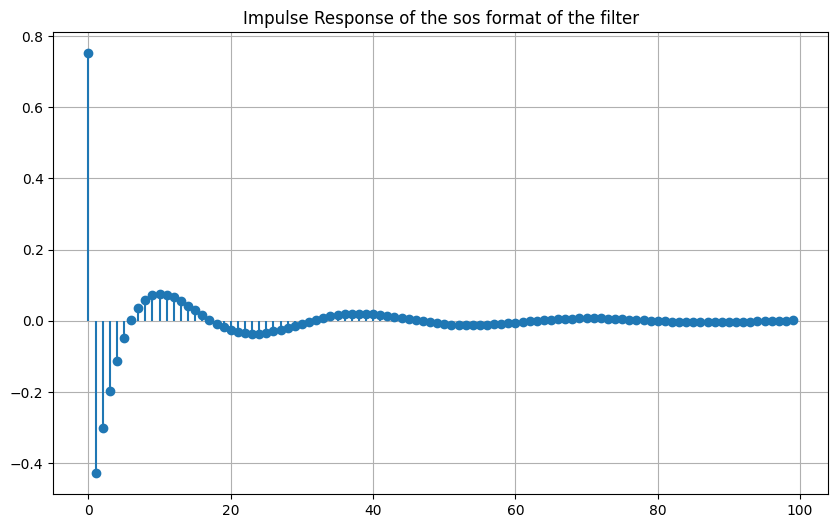

In [3]:
ndelta = 100
delta = np.zeros(ndelta);
delta[0]= 1
h_sos = sig.sosfilt(sos,delta)

plt.figure(figsize = (10,6))
plt.stem(np.arange(ndelta), h_sos, linefmt='-', markerfmt='o', basefmt=' ')
plt.title("Impulse Response of the sos format of the filter")
plt.grid(True)

### 1.3 Frequency response
We use this snippet to plot the frequency response

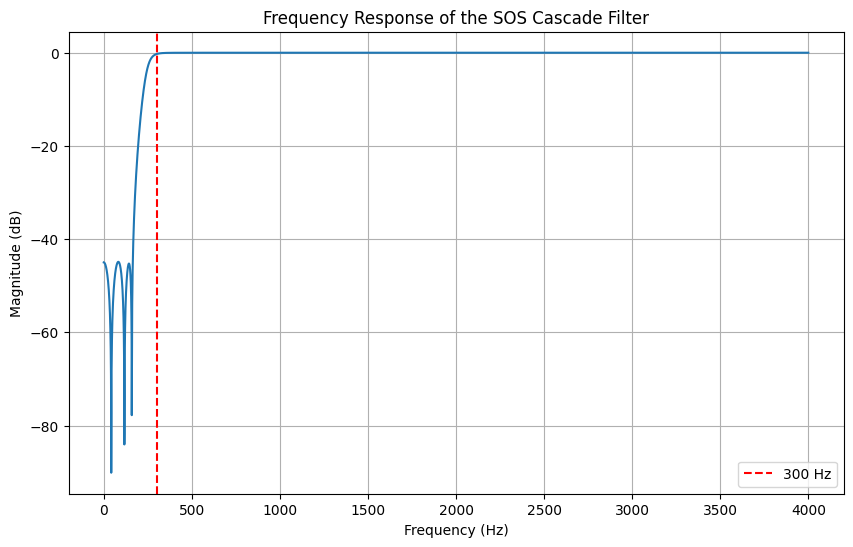

In [4]:
fs = 8000 #Hz
w_sos, H_sos = sig.sosfreqz(sos,worN=8000, fs=fs)
magnitude_sos = np.abs(H_sos)
magnitude_db_sos = 20 * np.log10(np.maximum(magnitude_sos, 1e-30))
plt.figure(figsize=(10, 6))
plt.plot(w_sos, magnitude_db_sos)
plt.axvline(x=300, color='r', linestyle='--', label='300 Hz')
plt.title('Frequency Response of the SOS Cascade Filter')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.grid(True)
plt.legend()
plt.show()



In [5]:

# Print the magnitude at 300 Hz in dB
idx_300hz = np.abs(w_sos - 300).argmin()
magnitude_300hz_db_sos = magnitude_db_sos[idx_300hz]
print(f"Magnitude at 300 Hz: {magnitude_300hz_db_sos:.2f} dB")

# Calculate the transition range and -3 dB frequency
#    Transition range: frequency range where magnitude drops from -1 dB to -3 dB
idx_neg1db = np.abs(magnitude_db_sos - (-1)).argmin()
idx_neg3db = np.abs(magnitude_db_sos - (-3)).argmin()
transition_range = np.abs( w_sos[idx_neg3db] - w_sos[idx_neg1db])
print(f"Transition Range: {transition_range:.2f} Hz")

#    -3 dB frequency
f_neg3db = w_sos[idx_neg3db]
print(f"-3 dB Frequency: {f_neg3db:.2f} Hz")

Magnitude at 300 Hz: -0.28 dB
Transition Range: 23.00 Hz
-3 dB Frequency: 250.00 Hz


# 2. Biquad to Lattice

## 2.1 The design

One can have in mind to simplify the $H(z)$ in the previous section as in to multiply the polynomial in order to obtain two polynomial of degree $6$ for both numerator and denumerator. and then use two cascade FIR (for numerator) and IIR (for denumerator) to implement the lattice version. This seems more reasonable then designing two lattice filters for each second order stage. Therefore we first, obtain the coefficients of design and then design two lattice filters.

In [6]:
num, den = sig.sos2tf(sos)
print("Numerator coeffs are:")
print(num)
print("Denumerator coeffs are:")
print(den)

Numerator coeffs are:
[  0.75143614  -4.48968197  11.19592224 -14.9153527   11.19592224
  -4.48968197   0.75143614]
Denumerator coeffs are:
[  1.          -5.40543839  12.22177589 -14.79202828  10.10543909
  -3.69422388   0.56449535]


It seems that the FIR part is symmetric. So we have to break this symmetry before we can design any lattice filter.

In [7]:

import sys
import os

# Add the parent directory to Python path to import the library
sys.path.append(os.path.abspath('..'))

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from filter_lattice import (
    FIRFilter, IIRFilter, LatticeFilter,
    FIRLatticeFilter, IIRLatticeFilter,
    tf2lattice
)

## 2.2 Breaking symmetry

There are two ways I can think of to break the symmetry. One, to use the built-in 
```sig.minimum_phase```
and the other is to add a small coeff at the beginning of the fir.

### 2.2.1 Minimum Phase

In [8]:
from scipy.signal import minimum_phase

num_min_phase = minimum_phase(num, method='homomorphic', n_fft=2**14)
num_max_phase = -num_min_phase[::-1]
num_min_phase.dtype
print(num_max_phase)
print(num_min_phase)

[ 0.86697311 -2.58976068  2.58952143 -0.86673516]
[ 0.86673516 -2.58952143  2.58976068 -0.86697311]


comparing the minimum phase version with the original one:

h_ref being: [  0.75143607  -4.48968207  11.19592292 -14.91535383  11.19592292
  -4.48968207   0.75143607]
num being: [  0.75143614  -4.48968197  11.19592224 -14.9153527   11.19592224
  -4.48968197   0.75143614]


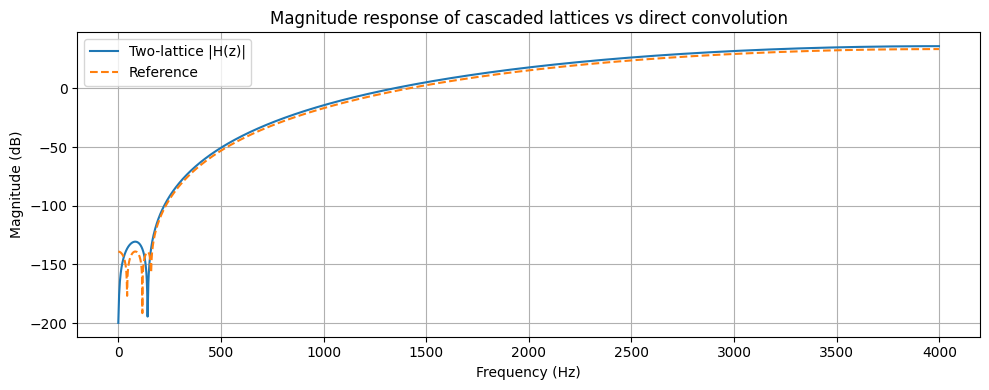

In [9]:
lat_M      = tf2lattice(num_min_phase,      type_of_filter="FIR",  dtype=np.float64)   # forward lattice
lat_M_inv  = tf2lattice(num_max_phase,  type_of_filter="FIR",  dtype=np.float64)   # reverse lattice

# ------------------------------------------------------------------
# 5.  Cascaded realisation  y[n] = M(z) · M(z-1)
#     – filter x through M(z)
#     – feed result into M(z-1)
# ------------------------------------------------------------------
def linphase_via_two_lattices(x: np.ndarray, lat1, lat2) -> np.ndarray:
    y1 = lat1.filter(x)          # forward minimum-phase section
    y2 = lat2.filter(y1)     # reverse section
    return y2

# ------------------------------------------------------------------
# 6.  Quick check: impulse and frequency responses
# ------------------------------------------------------------------
fs = 8000
imp = np.zeros(256); imp[0] = 1.0
h_two_lat = linphase_via_two_lattices(imp, lat_M,lat_M_inv )              # overall impulse resp.

# reference: direct convolution of M and its reverse
h_ref = np.convolve(num_min_phase, num_max_phase)
print("h_ref being: " + str(h_ref))
print("num being: " + str(num))
w, H_lat = sig.freqz(h_two_lat, worN=2048, fs=fs)
w, H_ref = sig.freqz(num,       worN=2048, fs=fs)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot(w, 20*np.log10(np.abs(H_lat)+1e-10), label="Two-lattice |H(z)|")
plt.plot(w, 20*np.log10(np.abs(H_ref)+1e-10), '--', label="Reference")
plt.title("Magnitude response of cascaded lattices vs direct convolution")
plt.xlabel("Frequency (Hz)"); plt.ylabel("Magnitude (dB)")
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

## 2.3 Frequency Response

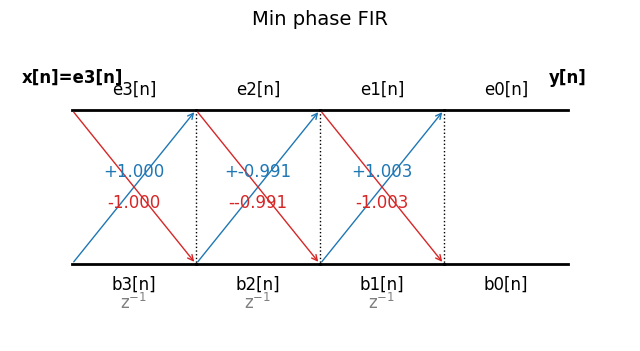

Lattice reflection coefficients for FIR minimum phase version: [ 1.00272717 -0.99098571  1.00027454]


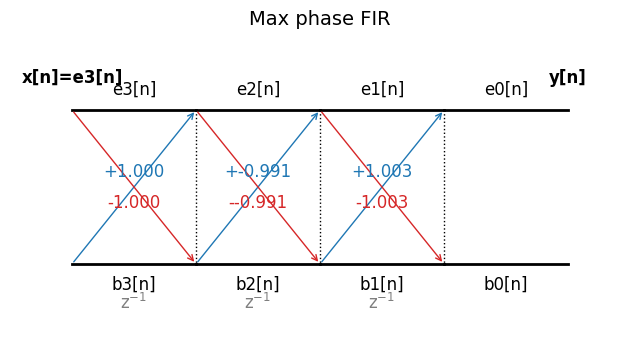

Lattice reflection coefficients for FIR maximum phase version: [ 1.00272717 -0.99098571  1.00027454]


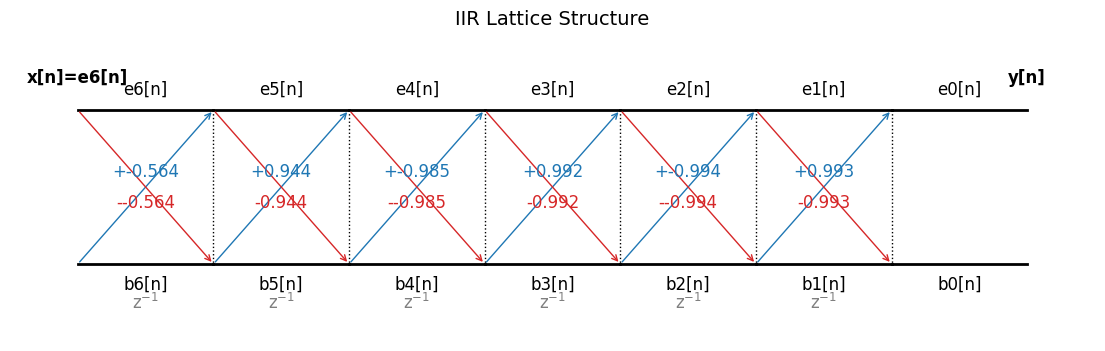

In [10]:
# FIR stage
fir_minphase = tf2lattice(num_min_phase, type_of_filter="FIR")
fir_minphase.plot(title="Min phase FIR")
print(f"Lattice reflection coefficients for FIR minimum phase version: {fir_minphase.reflection_coeffs}")

fir_maxphase = tf2lattice(num_max_phase, type_of_filter="FIR")
fir_maxphase.plot(title="Max phase FIR")
print(f"Lattice reflection coefficients for FIR maximum phase version: {fir_minphase.reflection_coeffs}")


# IIR stage
lattice_iir = tf2lattice(den, type_of_filter="IIR")
lattice_iir.plot()

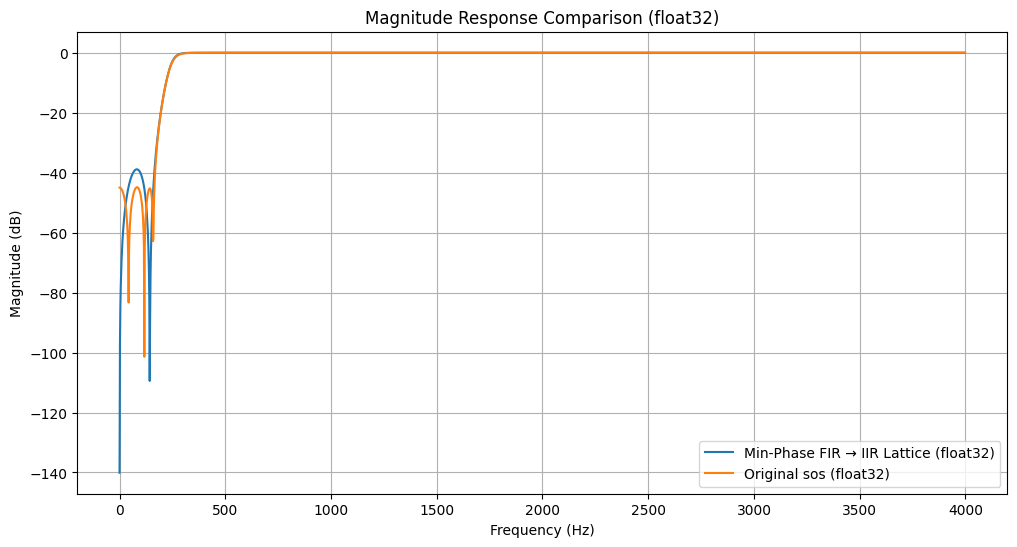

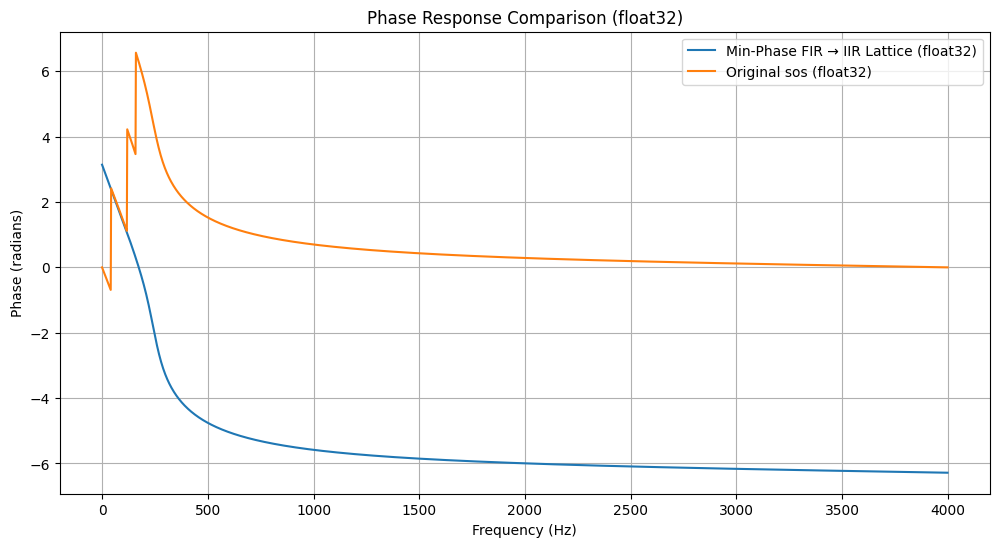

In [11]:
num_min_phase_32 = np.array(num_min_phase, dtype=np.float32)
num_max_phase_32 = np.array(num_max_phase, dtype=np.float32)
den_32 = np.array(den, dtype=np.float32)

# 1. Convert reflection coefficients to float32
fir_minphase_32 = tf2lattice(num_min_phase_32, type_of_filter="FIR", dtype=np.float32)
fir_maxphase_32 = tf2lattice(num_max_phase_32, type_of_filter="FIR", dtype=np.float32)
lattice_iir_32  = tf2lattice(den_32, type_of_filter="IIR", dtype=np.float32)

# 2. Prepare impulse in float32
fs = 8000
imp = np.zeros(2048, dtype=np.float32)
imp[0] = 1.0

# 3. Filter using float32 lattices
h_two_lat_32 = fir_minphase_32.filter(imp)
# If your linphase_via_two_lattices function expects FIR lattice objects, use the float32 ones:
out_minphase_32 = linphase_via_two_lattices(h_two_lat_32, lattice_iir_32, fir_maxphase_32)

# 4. Plot and compare
def plot_response(signal, label, fs=fs):
    w, h = sig.freqz(signal, worN=2048, fs=fs)
    plt.plot(w, 20 * np.log10(np.maximum(np.abs(h), 1e-30)), label=label)

plt.figure(figsize=(12, 6))
plot_response( num_max_phase[0]*num_min_phase[0] *out_minphase_32, 'Min-Phase FIR → IIR Lattice (float32)')
w_sos, H_sos = sig.sosfreqz(sos.astype(np.float32), worN=2048, fs=fs)
magnitude_sos = np.abs(H_sos)
magnitude_db_sos = 20 * np.log10(np.maximum(magnitude_sos, 1e-30))
plt.plot(w_sos, magnitude_db_sos, label='Original sos (float32)')
plt.title('Magnitude Response Comparison (float32)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
w, h1 = sig.freqz(out_minphase_32, worN=2048, fs=fs)
plt.plot(w, np.unwrap(np.angle(h1)), label='Min-Phase FIR → IIR Lattice (float32)')
plt.plot(w, np.unwrap(np.angle(H_sos)), label='Original sos (float32)')
plt.title('Phase Response Comparison (float32)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase (radians)')
plt.grid(True)
plt.legend()
plt.show()

